# Setup

## Imports & Options

In [1]:
# Packages
import crispr as cr 
from crispr.crispr_class import Crispr
import pertpy as pt
import muon
import os
import pandas as pd
import numpy as np
from config import DIR

# Initialize Object
kwargs_init = dict(
    assay=None, assay_protein=None, 
    col_gene_symbols="gene_symbols",
    layer_perturbation="X_pert", 
    col_cell_type="leiden", 
    col_sample_id="gemgroup", 
    col_batch="gemgroup", 
    col_perturbation="guide_ids", 
    col_guide_rna="guide_ids", 
    col_target_genes="guide_ids", 
    label_perturbation_type="KD", 
    key_control="NT", key_treatment=None)
file_path = f"{DIR}/replogle_2022_k562_esss.h5ad"
# file_path = f"{DIR}/replogle_2022_k562_esss_processed.h5ad"

## Data & Object

In [2]:
# Initialize Object
ann = Crispr(file_path, **kwargs_init)
    
# Subset Large Data to Save Time/Memory
ann.adata.obs[ann._columns["col_target_genes"]] = ann.adata.obs[
    ann._columns["col_target_genes"]].astype(str).replace("", ann._keys[
        "key_control"]).replace(np.nan,  ann._keys["key_control"])
ann.adata = ann.adata[ann.adata.obs["guide_ids"].isin(
    ["NT", "CDKN1A", "CDKN1A,CDKN1B", "CEBPA", "CEBPB", 
     "CEBPA,CEBPB", "DUSP9,KLF1", "SAMD1,UBASH3B", "TGFBR2", 
     "FEV,ISL2", "PRTG,TGFBR2", "JUN", "CLDN6,KLF1", 
     "CEBPE,SPI1", "PTPN13", "CEBPE,PTPN12", "CDKN1B,CDKN1C", 
     "FOXF1,FOXL2", "AHR,FEV", "CDKN1A,CDKN1B",])]  # subset for speed
    
# Add Control Keys Where Needed
ann.adata.obs[ann._columns["col_perturbation"]] = ann.adata.obs[
    ann._columns["col_perturbation"]].replace("", np.nan).replace(
        np.nan, ann._keys["key_control"])
    
# Fix Gene Columns
if ann._columns["col_gene_symbols"] in ann.adata.var.index.names:
    ann.adata.var = ann.adata.var.reset_index()
        
# Binary Perturbation Column      
conds = list(ann.adata.obs[ann._columns["col_perturbation"]].unique())
lab_tx = "Perturbed" if ann._keys[
    "key_treatment"] is None else ann._keys["key_treatment"]
ann.adata.obs[ann._columns["col_perturbation"] + "_old"] = ann.adata.obs[
    ann._columns["col_perturbation"]].copy()
ann.adata.obs[ann._columns[
    "col_perturbation"] + "_binary"] = ann.adata.obs[
        ann._columns["col_perturbation"]].apply(
            lambda x: lab_tx if x != ann._keys["key_control"] else x)
ann._keys["key_treatment"] = lab_tx
ann.adata

<<<CREATING OBJECT>>>

<<< LOADING FILE /home/asline01/projects/crispr/examples/data/replogle_2022_k562_esss.h5ad with sc.read()>>>


 AnnData object with n_obs × n_vars = 111445 × 33694
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'g

AnnData object with n_obs × n_vars = 17104 × 33694
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

## Preprocessing & Clustering

AnnData object with n_obs × n_vars = 17104 × 33694
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

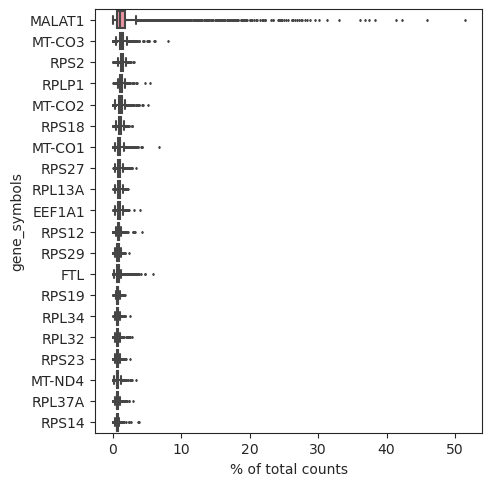


<<< FILTERING >>>

<<< DETECTING MITOCHONDRIAL GENES >>>

<<< PERFORMING QUALITY CONTROL >>>


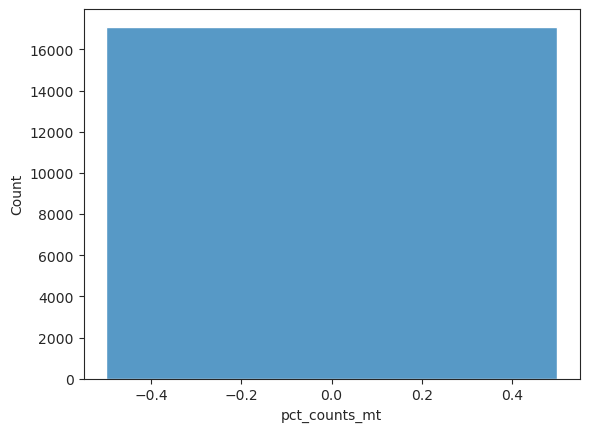

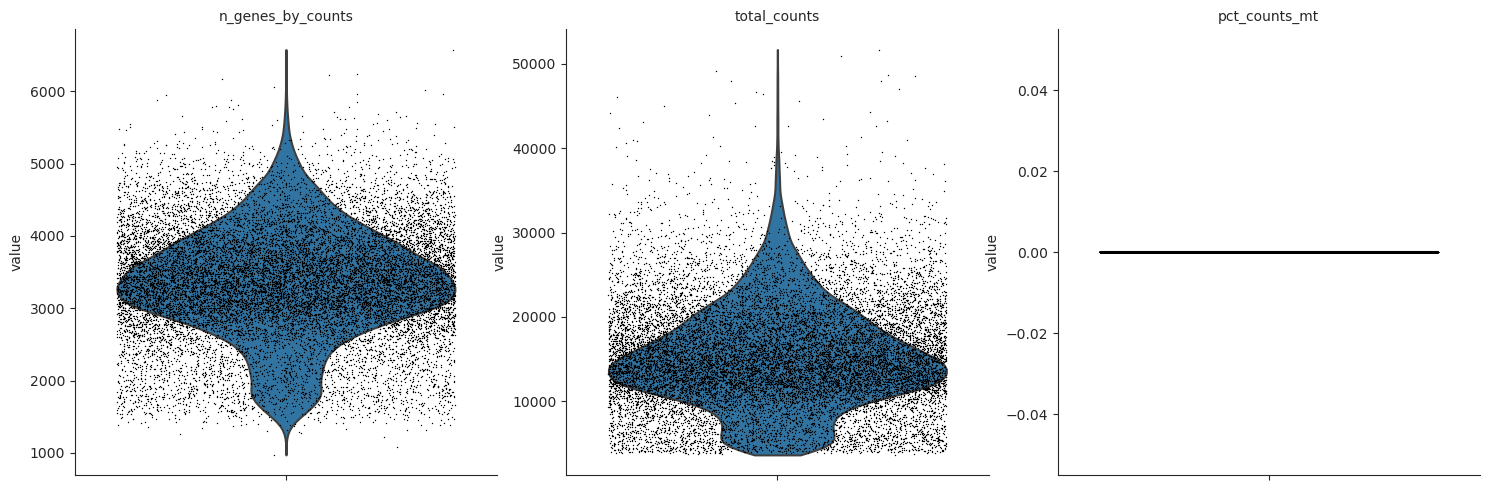

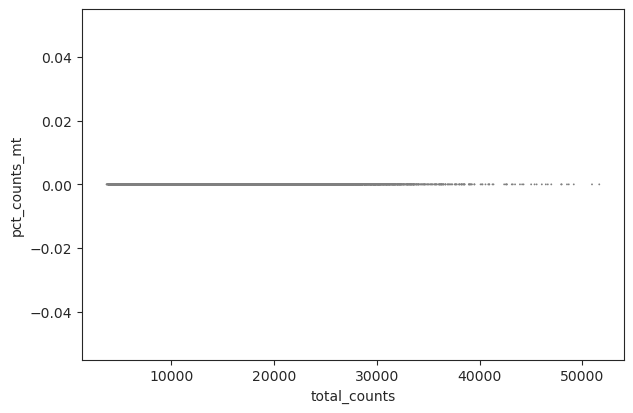

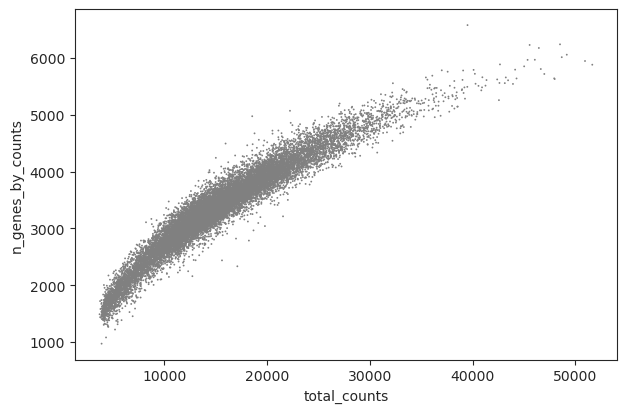


<<< NORMALIZING >>>

<<< DETECTING VARIABLE GENES >>>

<<< SCALING >>>



Un-used Keyword Arguments: {'col_cell_type': 'leiden', 'col_sample_id': 'gemgroup', 'col_batch': 'gemgroup', 'col_perturbation': 'guide_ids', 'col_guide_rna': 'guide_ids', 'col_target_genes': 'guide_ids', 'key_control': 'NT', 'key_treatment': 'Perturbed'}


<<< PERFORMING PCA >>>

 {'n_comps': None, 'use_highly_variable': True}


<<< COMPUTING NEIGHBORHOOD GRAPH >>>


<<< EMBEDDING: UMAP >>>


<<< CLUSTERING WITH LEIDEN METHOD >>>


<<< CREATING UMAP PLOTS >>>


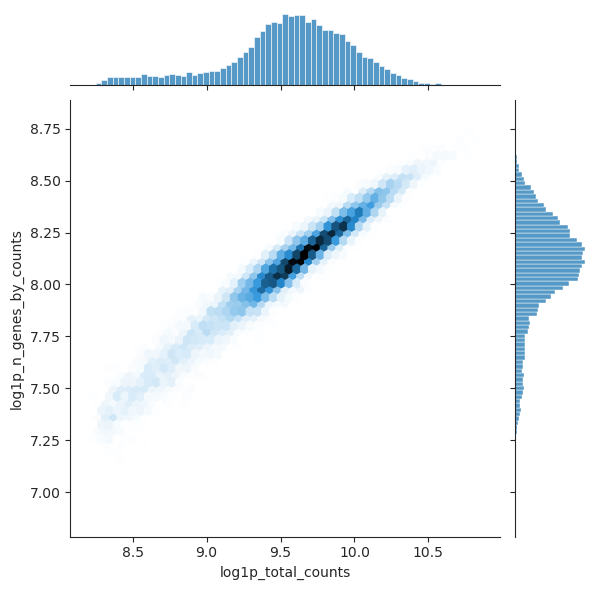

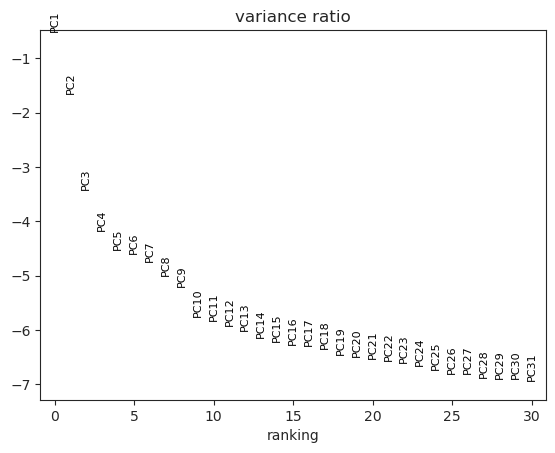

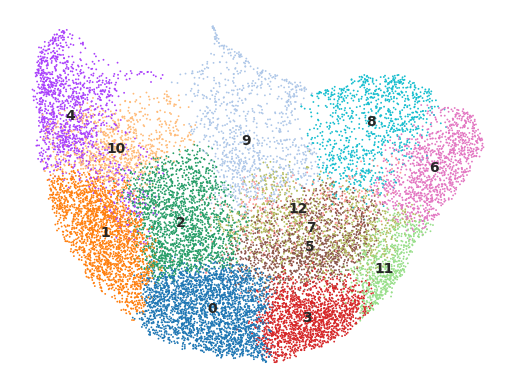

In [3]:
if "_processed" not in file_path:  # if not already processed & clustered
    # Preprocess
    process_kws = dict(kws_hvg=dict(min_mean=0.0125, max_mean=3, min_disp=0.5),
                    target_sum=1e4, max_genes_by_counts=2500, max_pct_mt=5, 
                    min_genes=200, min_cells=3, scale=10, regress_out=None)
    _ = ann.preprocess(**process_kws, kws_umap=None)  # preprocessing 

    # Cluster
    kws_pca = dict(n_comps=None, use_highly_variable=True)
    ann.cluster(paga=False, method_cluster="leiden", kws_pca=kws_pca, 
                kws_neighbors=None, kws_umap=None, kws_cluster=None)

# Basic Plots


<<< PLOTTING PRE-PROCESSING >>>

<<< PLOTTING GEX (Heatmap) >>>

<<< PLOTTING GEX (Violin) >>>


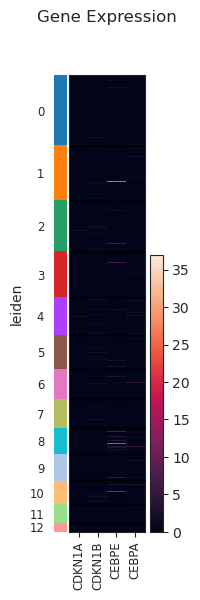

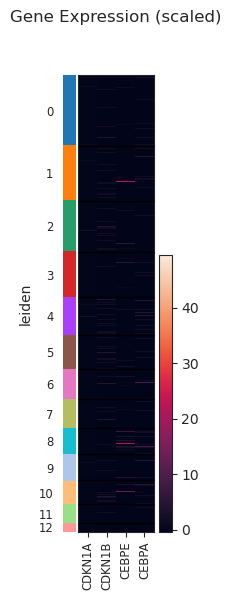

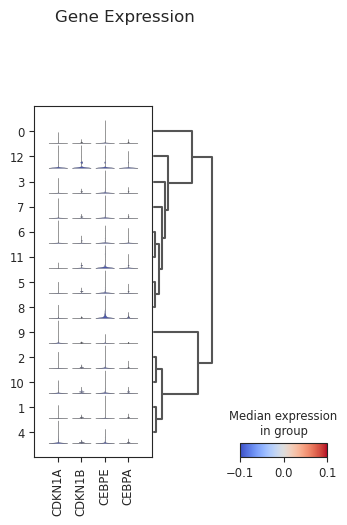

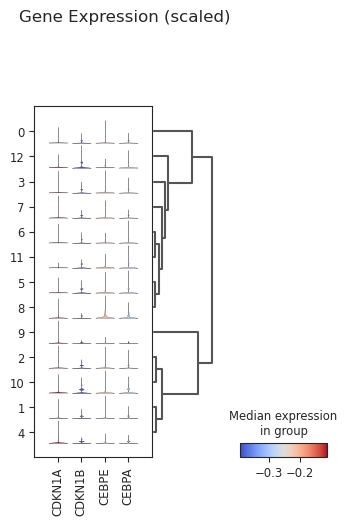


<<< PLOTTING GEX (Matrix) >>>
{'cmap': 'coolwarm', 'dendrogram': True, 'swap_axes': False}


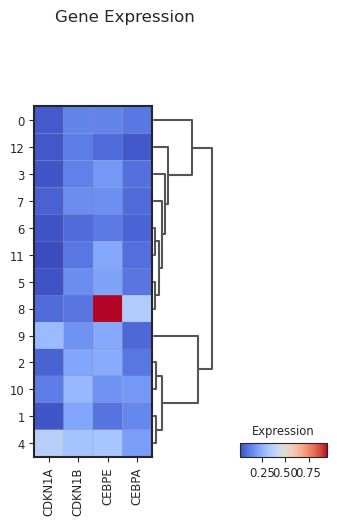

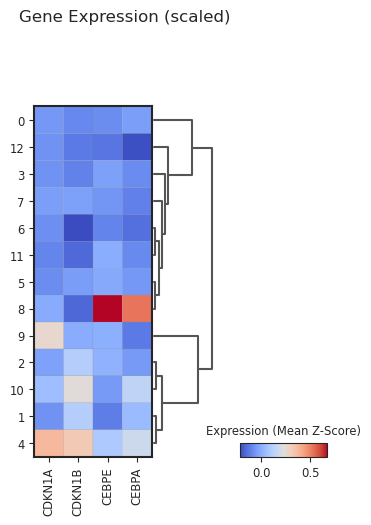


<<< PLOTTING UMAP >>>

<<< PLOTTING GEX ON UMAP >>>


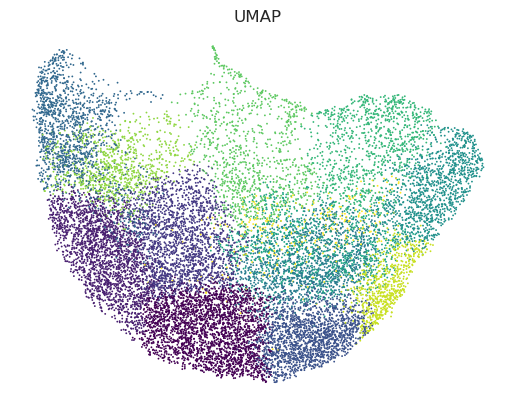

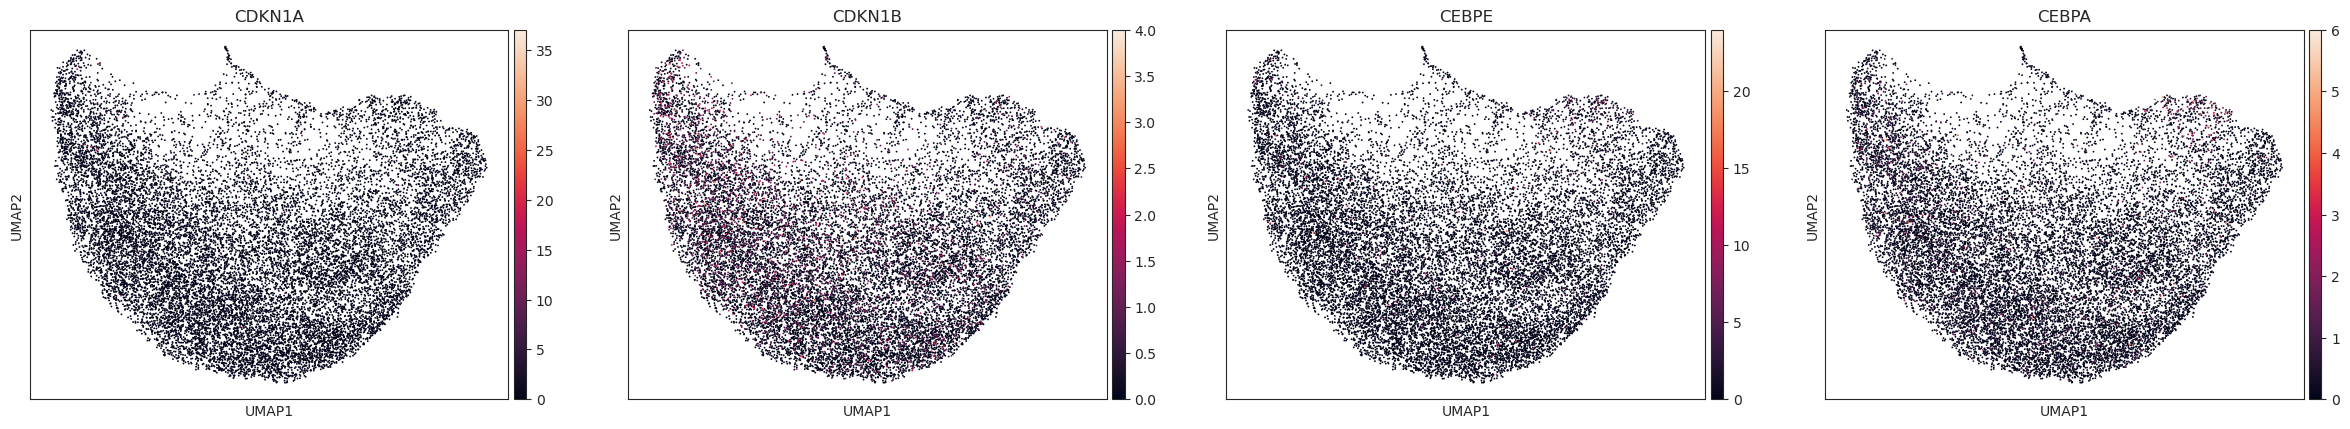

In [4]:
genes_subset = ["CDKN1A", "CDKN1B", "CEBPE", "CEBPA"]
figs = ann.plot(genes=genes_subset)

# Analyze

## Augur


Un-used Keyword Arguments: {'col_sample_id': 'gemgroup', 'col_batch': 'gemgroup', 'col_guide_rna': 'guide_ids', 'col_target_genes': 'guide_ids', 'layer': 'X_pert'}
AnnData object with n_obs × n_vars = 17104 × 19200
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'gui

Filtering samples with NT and Perturbed labels.

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

index
AAACCTGAGAAGAAGC-1-0    1
AAACCTGCACGAAGCA-1-0    6
AAACCTGGTATAATGG-1-0    8
AAACCTGTCACCGTAA-1-0    2
AAACCTGTCCGATATG-1-0    0
                       ..
TTTGGTTCATACGCTA-8-1    9
TTTGGTTCATTGGCGC-8-1    3
TTTGTCAAGCCACCTG-8-1    2
TTTGTCACACGAGGTA-8-1    6
TTTGTCAGTATAAACG-8-1    6
Name: cell_type, Length: 17104, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

                         1         6         8         2         0         3  \
mean_augur_score  0.518787  0.566451  0.632868  0.535601  0.514671  0.537460   
mean_auc          0.518787  0.566451  0.632868  0.535601  0.514671  0.537460   
mean_accuracy     0.499634  0.535018  0.568278  0.507473  0.517106  0.505421   
mean_precision    0.493152  0.555418  0.562769  0.509510  0.526254  0.518969   
mean_f1           0.449556  0.457408  0.595457  0.464130  0.465843  0.474410   
mean_recall       0.458889  0.438889  0.675556  0.473175  0.469683  0.486984   

                         5         4        11         7        10         9  \
mean_augur_score  0.621848  0.596610  0.544218  0.530578  0.564048  0.625351   
mean_auc          0.621848  0.596610  0.544218  0.530578  0.564048  0.625351   
mean_accuracy     0.575092  0.561722  0.520989  0.519158  0.536117  0.588388   
mean_precision    0.606332  0.554552  0.532733  0.518765  0.555233  0.614234   
mean_f1           0.540161  0.528278  0

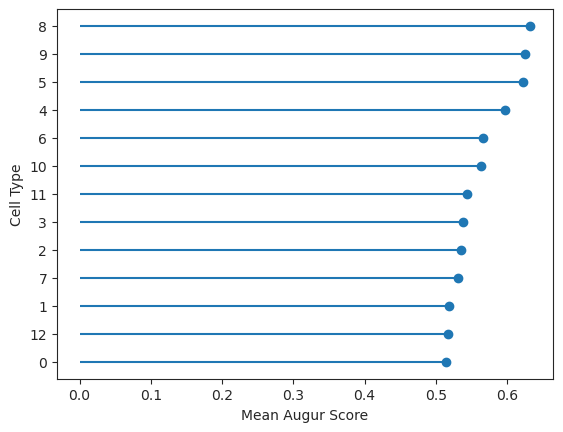

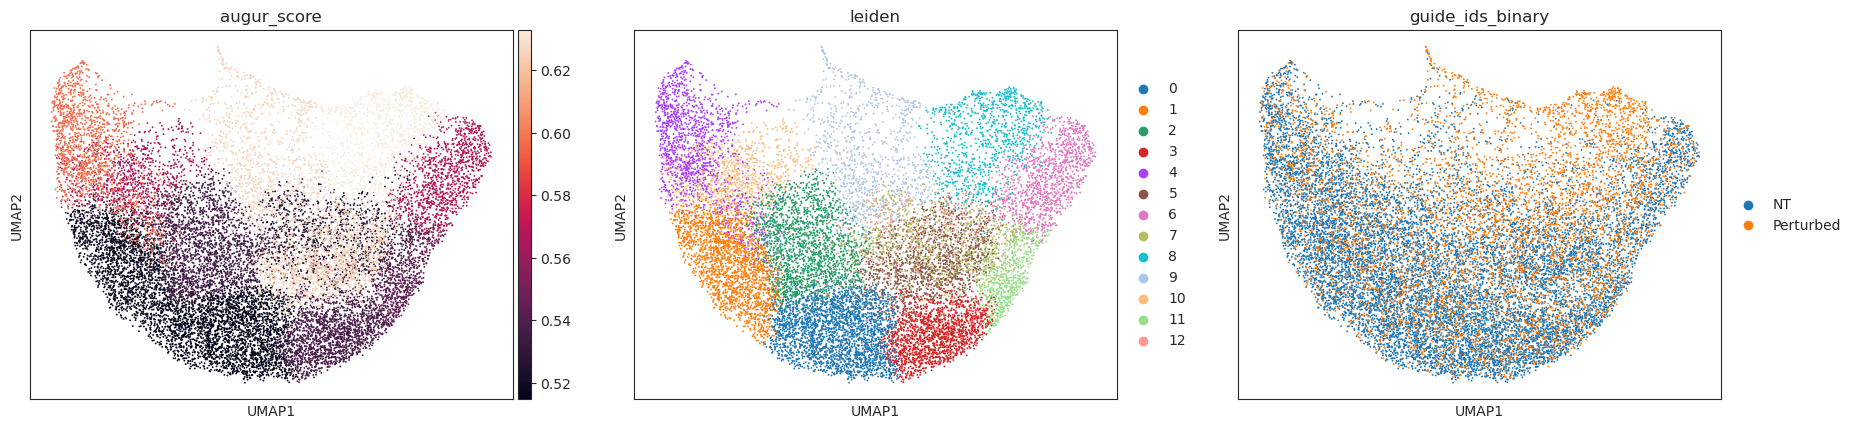

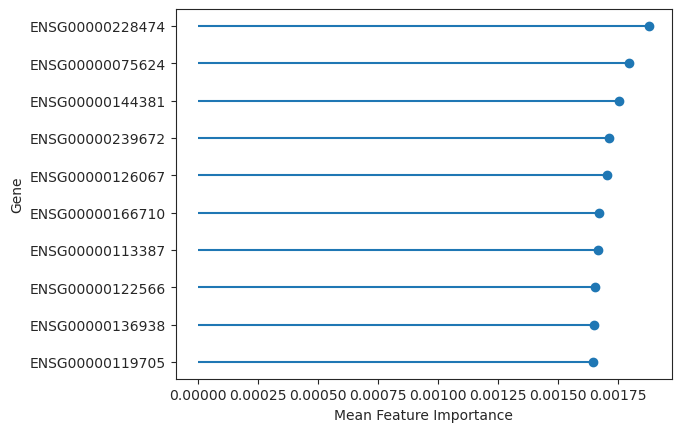

In [5]:
# Run Augur
# kws_augur_predict = None
kws_augur_predict = dict(span=1)
augur_data, augur_results, figs_augur = ann.run_augur(
    col_perturbation=ann._columns["col_perturbation"] + "_binary", 
    key_treatment=ann._keys["key_treatment"], 
    classifier="random_forest_classifier", n_threads=True,
    augur_mode="default", select_variance_features=True, n_folds=2,
    subsample_size=20, kws_augur_predict=kws_augur_predict)

## Distance Metrics


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_sample_id': 'gemgroup', 'col_batch': 'gemgroup', 'col_guide_rna': 'guide_ids', 'col_target_genes': 'guide_ids', 'key_control': 'NT', 'key_treatment': 'Perturbed'}


Output()

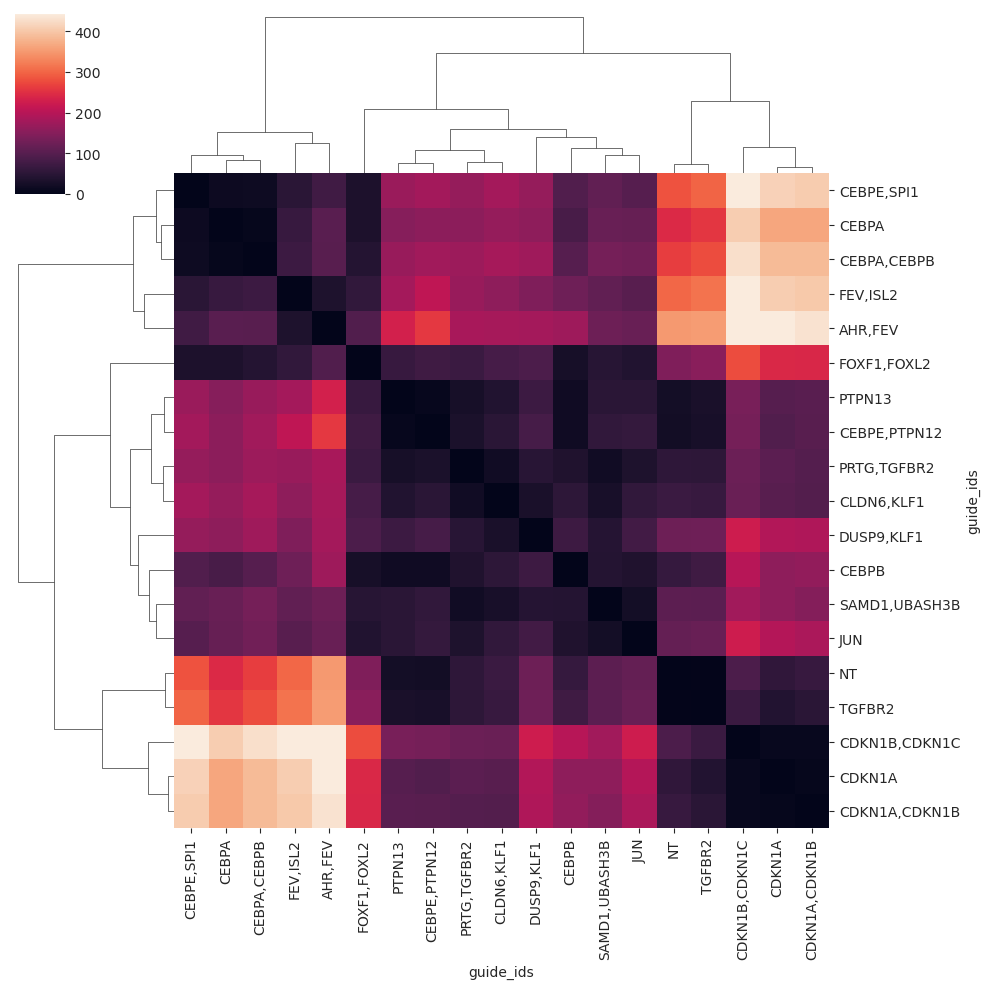

Output()

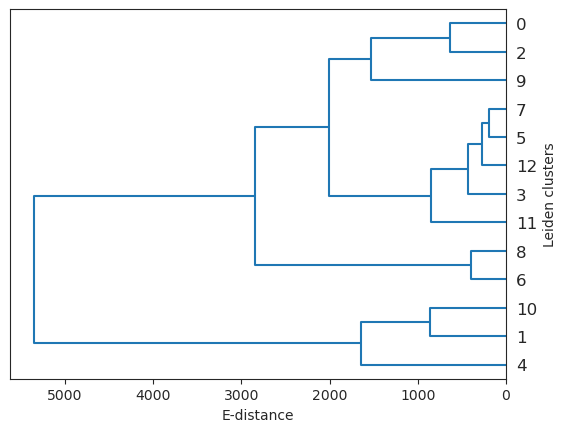

<Figure size 640x480 with 0 Axes>

In [6]:
fig_distance = ann.compute_distance(distance_type="edistance", method="X_pca")